In [2]:
%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

In [3]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略(不使用)的变量
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

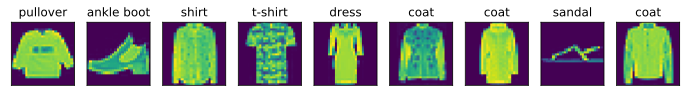

In [7]:
X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [9]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4

In [10]:
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer), batch_size, shuffle=True,
num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
batch_size, shuffle=False, num_workers=num_workers)

In [11]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'2.21 sec'

In [12]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [17]:
num_inputs = 784
num_outputs = 10
W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [18]:
W.attach_grad()
b.attach_grad()

In [21]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis = 1, keepdims = True)
    return X_exp / partition

In [24]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.34759867 0.22689402 0.07357835 0.33275953 0.01916944]
  [0.73942626 0.0456413  0.02498061 0.1749487  0.01500311]]
 <NDArray 2x5 @cpu(0)>, 
 [1. 1.]
 <NDArray 2 @cpu(0)>)

In [25]:
def net(X):
    return softmax(nd.dot(X.reshape(-1, num_inputs), W) + b)

In [33]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [31]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [34]:
accuracy(y_hat, y)

0.5

In [35]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [36]:
evaluate_accuracy(test_iter, net)

0.0856

In [37]:
y_hat.argmax(axis=1)


[2. 2.]
<NDArray 2 @cpu(0)>

In [38]:
num_epochs, lr = 5, 0.1

In [42]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

In [47]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,
              batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
train_ch3(net, train_iter, test_iter, cross_entropy,
          num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.5056, train acc 0.830, test acc 0.835
epoch 2, loss 0.4900, train acc 0.835, test acc 0.840
epoch 3, loss 0.4780, train acc 0.837, test acc 0.843
epoch 4, loss 0.4692, train acc 0.840, test acc 0.843
epoch 5, loss 0.4620, train acc 0.843, test acc 0.846


In [48]:
python

NameError: name 'python' is not defined

In [49]:
net

<function __main__.net(X)>

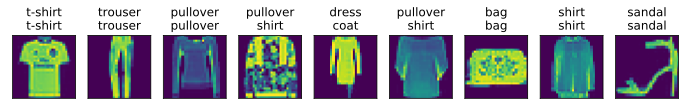

In [50]:
for X, y in test_iter:
    break
    
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

In [51]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn

In [52]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [54]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [55]:
loss = gloss.SoftmaxCrossEntropyLoss()

In [61]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.01})

In [62]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter,
              loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 0.4765, train acc 0.840, test acc 0.843
epoch 2, loss 0.4749, train acc 0.841, test acc 0.842
epoch 3, loss 0.4739, train acc 0.841, test acc 0.843
epoch 4, loss 0.4729, train acc 0.841, test acc 0.844
epoch 5, loss 0.4719, train acc 0.842, test acc 0.843


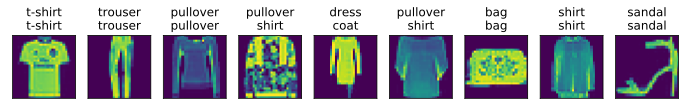

In [60]:
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

In [63]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

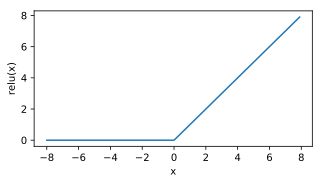

In [65]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

In [67]:
y.backward()

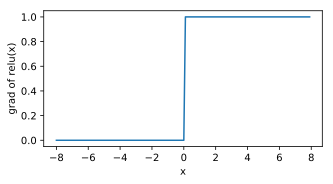

In [68]:
xyplot(x, x.grad, 'grad of relu')


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
<NDArray 160 @cpu(0)>

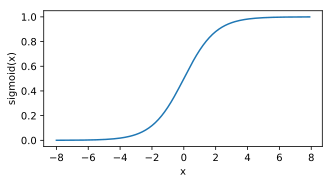

In [72]:
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'sigmoid')

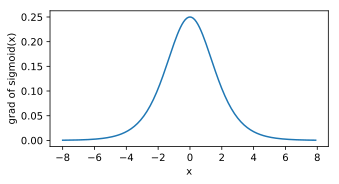

In [73]:
y.backward()
xyplot(x, x.grad, 'grad of sigmoid')

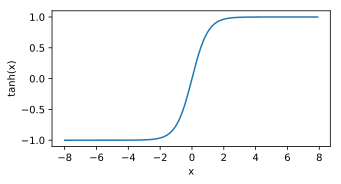

In [75]:
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'tanh')

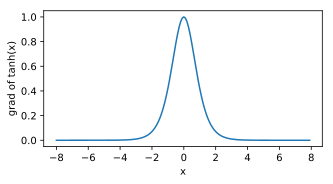

In [77]:
y.backward()
xyplot(x, x.grad, 'grad of tanh')

In [2]:
%matplotlib inline
import d2lzh as d2l
from mxnet import nd
from mxnet.gluon import loss as gloss

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

In [5]:
W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_outputs))
b2 = nd.zeros(num_outputs)

In [6]:
params = [W1, b1, W2, b2]

In [7]:
for param in params:
    param.attach_grad()

In [8]:
def relu(X):
    return nd.maximum(X, 0)

In [10]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [11]:
loss = gloss.SoftmaxCrossEntropyLoss()

In [19]:
num_epochs, lr = 10, 0.5
d2l.train_ch3(net , train_iter, test_iter, loss, num_epochs,
              batch_size, params, lr)

epoch 1, loss 0.6163, train acc 0.779, test acc 0.775
epoch 2, loss 0.6163, train acc 0.779, test acc 0.775
epoch 3, loss 0.6163, train acc 0.779, test acc 0.775
epoch 4, loss 0.6163, train acc 0.779, test acc 0.775
epoch 5, loss 0.6163, train acc 0.779, test acc 0.775
epoch 6, loss 0.6163, train acc 0.779, test acc 0.775
epoch 7, loss 0.6163, train acc 0.779, test acc 0.775
epoch 8, loss 0.6163, train acc 0.779, test acc 0.775
epoch 9, loss 0.6163, train acc 0.779, test acc 0.775
epoch 10, loss 0.6163, train acc 0.779, test acc 0.775


In [71]:
import d2lzh as d2l
from mxnet import gluon, init, autograd
from mxnet.gluon import data as gdata, loss as gloss, nn
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), nn.Dense(128), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.5})
num_epochs = 20
d2l.train_ch3(net, train_iter, test_iter, loss,
              num_epochs, batch_size, None, None, trainer)

epoch 1, loss 1.3570, train acc 0.492, test acc 0.731
epoch 2, loss 2.2643, train acc 0.293, test acc 0.344
epoch 3, loss 1.9245, train acc 0.299, test acc 0.497
epoch 4, loss 1.5761, train acc 0.353, test acc 0.266
epoch 5, loss 1.8122, train acc 0.282, test acc 0.220
epoch 6, loss 1.6671, train acc 0.311, test acc 0.410
epoch 7, loss 1.6814, train acc 0.325, test acc 0.117
epoch 8, loss 1.6604, train acc 0.330, test acc 0.402
epoch 9, loss 1.5614, train acc 0.373, test acc 0.355
epoch 10, loss 1.4644, train acc 0.401, test acc 0.446
epoch 11, loss 1.3570, train acc 0.435, test acc 0.289
epoch 12, loss 1.1290, train acc 0.541, test acc 0.703
epoch 13, loss 0.7941, train acc 0.686, test acc 0.723
epoch 14, loss 0.7203, train acc 0.717, test acc 0.719
epoch 15, loss 0.6168, train acc 0.758, test acc 0.792
epoch 16, loss 0.5828, train acc 0.787, test acc 0.828
epoch 17, loss 0.7058, train acc 0.728, test acc 0.759
epoch 18, loss 0.5841, train acc 0.775, test acc 0.802
epoch 19, loss 0.56

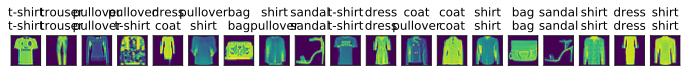

In [72]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
d2l.show_fashion_mnist(X[0:19], titles[0:19])

In [73]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))

In [74]:
poly_features = nd.concat(features, nd.power(features, 2),
                         nd.power(features, 3))

In [75]:
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)

In [76]:
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [77]:
features[:2], poly_features[:2], labels[:2]

(
 [[ 0.6975352]
  [-0.9390203]]
 <NDArray 2x1 @cpu(0)>, 
 [[ 0.6975352   0.48655537  0.3393895 ]
  [-0.9390203   0.8817591  -0.82798964]]
 <NDArray 2x3 @cpu(0)>, 
 [ 6.042308 -3.718058]
 <NDArray 2 @cpu(0)>)

In [83]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [84]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                           {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                           test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss',
         test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
         '\nbias:', net[0].bias.data().asnumpy)

final epoch: train loss 0.0 test loss 0.0
weight: [[-0.05316617  0.02265695  0.00030103]] 
bias: <bound method NDArray.asnumpy of 
[0.]
<NDArray 1 @cpu(0)>>


/Users/lanxuan/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


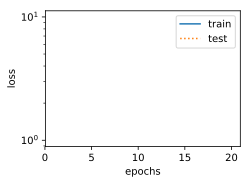

In [85]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

In [17]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'),
nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [18]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, 
              None, trainer)
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)
features[:2], poly_features[:2], labels[:2]

epoch 1, loss 0.8097, train acc 0.697, test acc 0.815
epoch 2, loss 0.4838, train acc 0.821, test acc 0.848
epoch 3, loss 0.4297, train acc 0.842, test acc 0.857
epoch 4, loss 0.3974, train acc 0.853, test acc 0.866
epoch 5, loss 0.3736, train acc 0.862, test acc 0.869


(
 [[-0.960419 ]
  [-1.9106549]]
 <NDArray 2x1 @cpu(0)>, 
 [[-0.960419    0.92240465 -0.88589495]
  [-1.9106549   3.650602   -6.975041  ]]
 <NDArray 2x3 @cpu(0)>, 
 [ -4.156193 -48.734867]
 <NDArray 2 @cpu(0)>)

In [19]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [20]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())

final epoch: train loss 0.0 test loss 0.0
weight: [[-0.02941212  0.00292248  0.01087932]] 
bias: [0.]


/Users/lanxuan/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


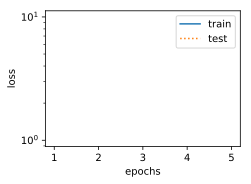

In [21]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

In [31]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05
features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [33]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1, ))
    w.attach_grad()
    b.attach_grad()
    return[w, b]
def l2_penalty(w):
    return (w**2).sum()/2

In [39]:
batch_size, num_epochs, lr = 1, 100, 0.003

In [40]:
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
train_features, train_labels), batch_size, shuffle=True)

In [41]:
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                            train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                           test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

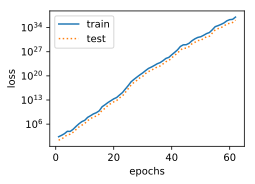

L2 norm of w: 2.9888156e+27


In [44]:
fit_and_plot(lambd=3)

In [47]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                             {'learning_rate': lr})
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                             {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                            train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                           test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                    range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

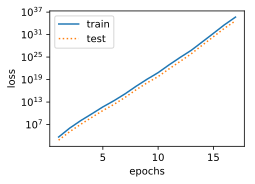

L2 norm of w: nan


In [48]:
fit_and_plot_gluon(0)

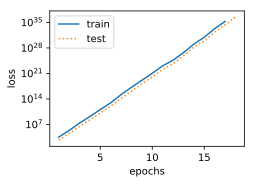

L2 norm of w: nan


In [49]:
fit_and_plot_gluon(3)

In [50]:
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn

def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return x.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) < keep_prob
    return mask * X / keep_prob

In [53]:
X = nd.arange(16).reshape((2, 8))
dropout(X, 0.5)


[[ 0.  0.  4.  0.  8. 10. 12. 14.]
 [ 0. 18.  0. 22.  0. 26. 28. 30.]]
<NDArray 2x8 @cpu(0)>